# Vidit Dave Final Project (USC ID: 7547192056)
# Git Username: Vidit631

In [1]:
!pip install scikit-image
import os
import json
from pathlib import Path
import shutil
import logging
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm
from skimage import io
import random
import tensorflow as tf
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Activation, Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, regularizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 33.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 16.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


# 1. Identification of Frost in Martian HiRISE Images

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/kaggle/input/mars-dataset/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/kaggle/input/source/train_source_images.txt')
validate_ids = load_text_ids('/kaggle/input/source/val_source_images.txt')
test_ids = load_text_ids('/kaggle/input/source/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## 1(b) Loading and pre processing the data

In [4]:
# Correct the function name from '_inner_function' to 'inner_function'
def load_and_preprocess(img_loc, label):
    def inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])  # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

2023-12-11 01:52:38.127499: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:52:38.127619: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:52:38.127753: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:52:38.127857: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:52:38.127957: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:52:38.128173: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:52:38.128266: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

## 1(c) CNN + MLP

In [7]:
def image_augment(image, label):
    # Apply augmentation techniques
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Randomly rotate the image by 0, 90, 180, or 270 degrees
    rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=rotations)

    return image, label

# Ensure that the dataset is being augmented
augmented_training_dataset = tf_dataset_train.map(image_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

with tpu_strategy.scope():
    cnn_classifier = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Flatten(),

        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
cnn_classifier.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

stop_early = EarlyStopping(monitor='val_loss', patience=5)
training_history = cnn_classifier.fit(augmented_training_dataset, epochs=20, validation_data=tf_dataset_val, 
                    callbacks=[stop_early])

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


21:10:16 | INFO  | tpu_strategy_util | Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


21:10:16 | INFO  | tpu_strategy_util | Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


21:10:20 | INFO  | tpu_strategy_util | Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


21:10:20 | INFO  | tpu_system_metadata | Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


21:10:20 | INFO  | tpu_system_metadata | *** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


21:10:20 | INFO  | tpu_system_metadata | *** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


21:10:20 | INFO  | tpu_system_metadata | *** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


21:10:20 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)
2023-12-10 21:10:21.255731: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:21.255871: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:23.368308: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:23.386470: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:23.404341: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:23.421410: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriori

Epoch 1/20


21:10:24 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
21:10:25 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 21:10:26.799701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-12-10 21:10:27.806638: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:27.809972: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2

  2/928 [..............................] - ETA: 1:23 - loss: 5.5916 - accuracy: 0.5938   

2023-12-10 21:10:59.392661: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:59.392783: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:59.392889: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:59.392983: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:59.393111: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:59.393236: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:10:59.393321: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 60/928 [>.............................] - ETA: 1:15 - loss: 4.8560 - accuracy: 0.6125

2023-12-10 21:11:04.440531: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:11:04.440771: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:11:04.440912: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


118/928 [==>...........................] - ETA: 1:10 - loss: 4.6978 - accuracy: 0.6311

2023-12-10 21:11:09.499886: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:11:09.500026: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 21:11:09.500238: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


403/928 [============>.................] - ETA: 45s - loss: 4.5007 - accuracy: 0.6646

2023-12-10 21:11:34.501396: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


677/928 [====================>.........] - ETA: 21s - loss: 4.4048 - accuracy: 0.6828

2023-12-10 21:11:58.435224: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - ETA: 0s - loss: 4.3335 - accuracy: 0.6954

21:12:30 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 21:12:30.707904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 164s 139ms/step - loss: 4.3335 - accuracy: 0.6954 - val_loss: 4.0047 - val_accuracy: 0.7804
Epoch 2/20
928/928 [==============================] - 116s 125ms/step - loss: 3.8846 - accuracy: 0.7454 - val_loss: 3.9442 - val_accuracy: 0.5999
Epoch 3/20
928/928 [==============================] - 116s 125ms/step - loss: 3.4861 - accuracy: 0.7723 - val_loss: 3.2746 - val_accuracy: 0.8127
Epoch 4/20
928/928 [==============================] - 116s 125ms/step - loss: 3.0888 - accuracy: 0.8059 - val_loss: 2.9709 - val_accuracy: 0.8007
Epoch 5/20
928/928 [==============================] - 116s 124ms/step - loss: 2.7237 - accuracy: 0.8228 - val_loss: 2.6879 - val_accuracy: 0.8157
Epoch 6/20
928/928 [==============================] - 117s 125ms/step - loss: 2.3975 - accuracy: 0.8376 - val_loss: 2.1633 - val_accuracy: 0.9121
Epoch 7/20
928/928 [==============================] - 116s 125ms/step - loss: 2.1207 - accuracy: 0.8478 - val_loss: 2.0155 - val_accura

In [10]:
from sklearn.metrics import classification_report
def assess_performance(model, data, display_output=True):
  actual_labels = []
  predicted_labels = []
  for images, labels in data:
    predictions = model.predict(images, verbose=0)
    actual_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(predictions, axis=1))

  performance_report = classification_report(actual_labels, predicted_labels)
  return performance_report

report_train = assess_performance(cnn_classifier, tf_dataset_train)
report_validation = assess_performance(cnn_classifier, tf_dataset_val)
report_test = assess_performance(cnn_classifier, tf_dataset_test)

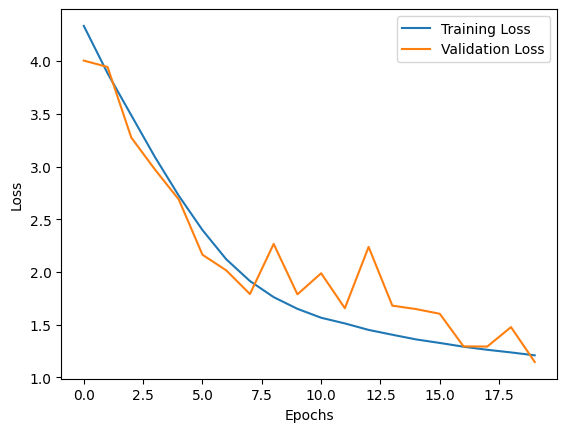

In [11]:
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

cnn_checkpoint = ModelCheckpoint('cnn_best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [12]:
print(report_test)

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      4418
           1       0.93      0.96      0.95      8405

    accuracy                           0.93     12823
   macro avg       0.92      0.91      0.92     12823
weighted avg       0.93      0.93      0.93     12823



# 1(d) Transfer Learning

In [5]:
class CustomAugmentationLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs, training=None):
        if training:
            # Apply augmentations only during training
            inputs = tf.image.random_flip_left_right(inputs)
            inputs = tf.image.random_flip_up_down(inputs)
            inputs = tf.image.random_brightness(inputs, max_delta=0.2)
            inputs = tf.image.random_contrast(inputs, lower=0.8, upper=0.9)
            rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
            inputs = tf.image.rot90(inputs, k=rotations)
        return inputs

In [6]:
true_labels = []
for _, labels in tf_dataset_train:
    true_labels.extend(labels.numpy())
true_labels_array = np.array(true_labels)

balanced_class_weights = compute_class_weight('balanced', classes=np.unique(true_labels_array), y=true_labels_array)
weight_dictionary = {i: weight for i, weight in enumerate(balanced_class_weights)}

# Efficient Net

In [7]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


01:53:53 | INFO  | tpu_strategy_util | Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


01:53:54 | INFO  | tpu_strategy_util | Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


01:53:59 | INFO  | tpu_strategy_util | Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


01:53:59 | INFO  | tpu_system_metadata | Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


01:53:59 | INFO  | tpu_system_metadata | *** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


01:53:59 | INFO  | tpu_system_metadata | *** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


01:53:59 | INFO  | tpu_system_metadata | *** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


01:53:59 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [8]:
with tpu_strategy.scope():
    efficientnet_base = EfficientNetB0(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
    efficientnet_base.trainable = False

    efficientnet_model = models.Sequential([
        CustomAugmentationLayer(),
        efficientnet_base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')  # Assuming binary classification
    ])

fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00000001)
efficientnet_model.compile(optimizer=fine_tune_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

stop_early_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
efficientnet_history = efficientnet_model.fit(tf_dataset_train, 
                    epochs=20, 
                    validation_data=tf_dataset_val,
                    callbacks=[stop_early_callback],
                    batch_size=8,
                    class_weight=weight_dictionary)

2023-12-11 01:53:59.146554: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:53:59.387404: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


16705208/16705208 [==============================] - 0s 0us/step


2023-12-11 01:54:12.587804: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:12.588571: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:12.589223: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:12.589729: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:12.590287: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:12.591057: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:12.591887: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/20


01:54:26 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=float64>),), {}]
01:54:32 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=float64>),), {}]
2023-12-11 01:54:37.463482: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-12-11 01:54:39.070323: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:39.0735

  3/928 [..............................] - ETA: 1:06 - loss: 0.7905 - accuracy: 0.5417 

2023-12-11 01:54:50.564194: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.564333: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.564428: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.564515: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.564609: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.564723: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.564813: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  5/928 [..............................] - ETA: 1:18 - loss: 0.7644 - accuracy: 0.5500

2023-12-11 01:54:50.789229: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.789341: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:50.789485: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  8/928 [..............................] - ETA: 1:20 - loss: 0.8171 - accuracy: 0.5469

2023-12-11 01:54:51.061734: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 60/928 [>.............................] - ETA: 1:16 - loss: 0.8870 - accuracy: 0.5005

2023-12-11 01:54:55.644828: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:54:55.645097: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


396/928 [===========>..................] - ETA: 47s - loss: 0.8741 - accuracy: 0.4951

2023-12-11 01:55:25.627811: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


739/928 [======================>.......] - ETA: 16s - loss: 0.8719 - accuracy: 0.4960

2023-12-11 01:55:55.701571: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - ETA: 0s - loss: 0.8700 - accuracy: 0.4972

01:56:16 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-11 01:56:18.119010: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 160s 146ms/step - loss: 0.8700 - accuracy: 0.4972 - val_loss: 0.6543 - val_accuracy: 0.6782
Epoch 2/20
 50/928 [>.............................] - ETA: 2:18 - loss: 0.8145 - accuracy: 0.5150

2023-12-11 01:57:14.894854: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - 118s 126ms/step - loss: 0.8590 - accuracy: 0.5015 - val_loss: 0.6552 - val_accuracy: 0.6782
Epoch 3/20
928/928 [==============================] - 117s 126ms/step - loss: 0.8602 - accuracy: 0.5002 - val_loss: 0.6564 - val_accuracy: 0.6782
Epoch 4/20
 84/928 [=>............................] - ETA: 2:08 - loss: 0.8482 - accuracy: 0.5026

2023-12-11 02:01:15.776971: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - 117s 126ms/step - loss: 0.8546 - accuracy: 0.5034 - val_loss: 0.6576 - val_accuracy: 0.6782
Epoch 5/20
928/928 [==============================] - 118s 127ms/step - loss: 0.8584 - accuracy: 0.4988 - val_loss: 0.6539 - val_accuracy: 0.6782
Epoch 6/20
928/928 [==============================] - 118s 126ms/step - loss: 0.8535 - accuracy: 0.4988 - val_loss: 0.6564 - val_accuracy: 0.6782
Epoch 7/20
928/928 [==============================] - 118s 127ms/step - loss: 0.8475 - accuracy: 0.5015 - val_loss: 0.6603 - val_accuracy: 0.6782
Epoch 8/20
928/928 [==============================] - 117s 126ms/step - loss: 0.8493 - accuracy: 0.5019 - val_loss: 0.6597 - val_accuracy: 0.6782
Epoch 9/20
928/928 [==============================] - 118s 126ms/step - loss: 0.8489 - accuracy: 0.5028 - val_loss: 0.6600 - val_accuracy: 0.6782
Epoch 10/20
928/928 [==============================] - 122s 132ms/step - loss: 0.8494 - accuracy: 0.4996 - val_loss: 0.6592 - val_accur

In [9]:
def assess_performance(model, data, display_output=True):
  actual_labels = []
  predicted_labels = []
  for images, labels in data:
    predictions = model.predict(images, verbose=0)
    actual_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(predictions, axis=1))

  performance_report = classification_report(actual_labels, predicted_labels)
  return performance_report

report_train = assess_performance(efficientnet_model, tf_dataset_train)
report_validation = assess_performance(efficientnet_model, tf_dataset_val)
report_test = assess_performance(efficientnet_model, tf_dataset_test)

2023-12-11 02:14:55.839718: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
02:25:02 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, (<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>,), {}]
2023-12-11 02:25:04.061936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F

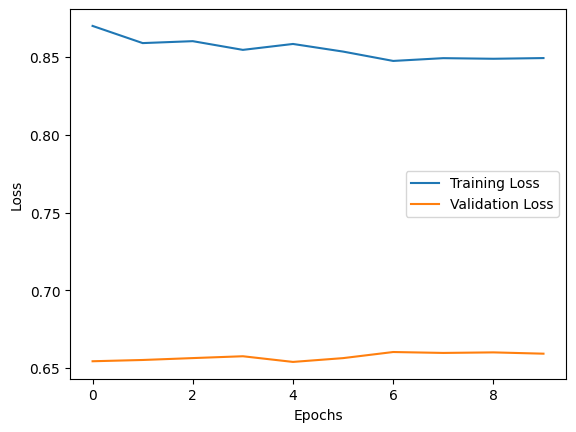

In [10]:
plt.plot(efficientnet_history.history['loss'], label='Training Loss')
plt.plot(efficientnet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

efficientnet_checkpoint = ModelCheckpoint('efficientnet_best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [11]:
print(report_test)

              precision    recall  f1-score   support

           0       0.34      1.00      0.51      4418
           1       0.00      0.00      0.00      8405

    accuracy                           0.34     12823
   macro avg       0.17      0.50      0.26     12823
weighted avg       0.12      0.34      0.18     12823



# Resnet

In [7]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


23:53:09 | INFO  | tpu_strategy_util | Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


23:53:09 | INFO  | tpu_strategy_util | Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


23:53:14 | INFO  | tpu_strategy_util | Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


23:53:14 | INFO  | tpu_system_metadata | Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


23:53:14 | INFO  | tpu_system_metadata | *** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


23:53:14 | INFO  | tpu_system_metadata | *** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


23:53:14 | INFO  | tpu_system_metadata | *** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


23:53:14 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [10]:
with tpu_strategy.scope():
    resnet_base_model = ResNet50(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
    resnet_base_model.trainable = False

    stop_early_resnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    resnet_classifier = models.Sequential([
        CustomAugmentationLayer(),
        resnet_base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])

resnet_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
resnet_classifier.compile(optimizer=resnet_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet_training_history = resnet_classifier.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[stop_early_resnet], class_weight=weight_dictionary, batch_size=8)

Epoch 1/20


23:55:44 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=float64>),), {}]
23:55:48 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=float64>),), {}]
2023-12-10 23:55:50.757410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-12-10 23:55:51.982499: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:55:51.9859

  3/928 [..............................] - ETA: 1:10 - loss: 0.8355 - accuracy: 0.4375 

2023-12-10 23:56:05.706973: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:05.707090: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:05.707175: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:05.707306: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:05.707429: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:05.707537: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:05.707642: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  5/928 [..............................] - ETA: 1:15 - loss: 0.7923 - accuracy: 0.4563

2023-12-10 23:56:05.944204: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 59/928 [>.............................] - ETA: 1:15 - loss: 0.7326 - accuracy: 0.5270

2023-12-10 23:56:10.637896: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:10.725899: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


118/928 [==>...........................] - ETA: 1:10 - loss: 0.7166 - accuracy: 0.5403

2023-12-10 23:56:15.774388: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:56:15.774863: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


234/928 [======>.......................] - ETA: 1:00 - loss: 0.6947 - accuracy: 0.5751

2023-12-10 23:56:25.737002: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.6061

23:57:31 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 23:57:33.344990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 163s 152ms/step - loss: 0.6623 - accuracy: 0.6061 - val_loss: 0.8064 - val_accuracy: 0.4168
Epoch 2/20
 77/928 [=>............................] - ETA: 2:20 - loss: 0.6478 - accuracy: 0.6238

2023-12-10 23:58:40.362152: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 23:58:40.362785: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - 117s 126ms/step - loss: 0.6302 - accuracy: 0.6402 - val_loss: 0.4722 - val_accuracy: 0.7830
Epoch 3/20
928/928 [==============================] - 116s 125ms/step - loss: 0.6200 - accuracy: 0.6489 - val_loss: 0.3928 - val_accuracy: 0.8803
Epoch 4/20
928/928 [==============================] - 116s 124ms/step - loss: 0.6100 - accuracy: 0.6596 - val_loss: 0.6105 - val_accuracy: 0.6087
Epoch 5/20
928/928 [==============================] - 116s 125ms/step - loss: 0.6063 - accuracy: 0.6653 - val_loss: 0.3812 - val_accuracy: 0.8783
Epoch 6/20
928/928 [==============================] - 117s 125ms/step - loss: 0.6015 - accuracy: 0.6696 - val_loss: 0.4866 - val_accuracy: 0.7499
Epoch 7/20
928/928 [==============================] - 116s 124ms/step - loss: 0.5973 - accuracy: 0.6748 - val_loss: 0.4292 - val_accuracy: 0.8191
Epoch 8/20
928/928 [==============================] - 116s 125ms/step - loss: 0.5988 - accuracy: 0.6712 - val_loss: 0.5384 - val_accura

In [11]:
def assess_performance(model, data, display_output=True):
  actual_labels = []
  predicted_labels = []
  for images, labels in data:
    predictions = model.predict(images, verbose=0)
    actual_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(predictions, axis=1))

  performance_report = classification_report(actual_labels, predicted_labels)
  return performance_report

report_train = assess_performance(resnet_classifier, tf_dataset_train)
report_validation = assess_performance(resnet_classifier, tf_dataset_val)
report_test = assess_performance(resnet_classifier, tf_dataset_test)

2023-12-11 00:35:33.485887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
00:45:41 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, (<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>,), {}]
2023-12-11 00:45:43.242864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


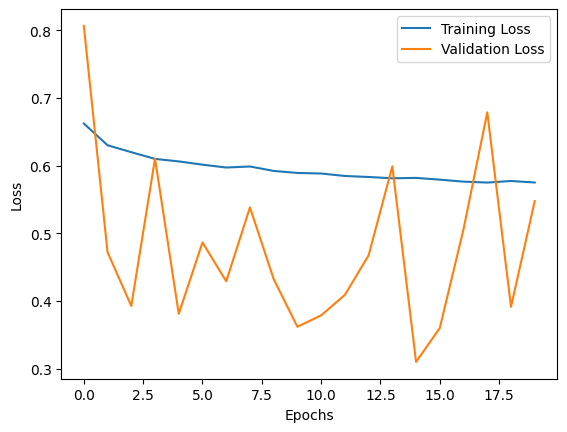

In [12]:
plt.plot(resnet_training_history.history['loss'], label='Training Loss')
plt.plot(resnet_training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

resnet_checkpoint = ModelCheckpoint('resnet_best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [13]:
print(report_test)

              precision    recall  f1-score   support

           0       0.61      0.94      0.74      4418
           1       0.95      0.68      0.80      8405

    accuracy                           0.77     12823
   macro avg       0.78      0.81      0.77     12823
weighted avg       0.84      0.77      0.78     12823



# VGG

In [5]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


01:17:30 | INFO  | tpu_strategy_util | Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


01:17:30 | INFO  | tpu_strategy_util | Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


01:17:35 | INFO  | tpu_strategy_util | Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


01:17:35 | INFO  | tpu_system_metadata | Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


01:17:35 | INFO  | tpu_system_metadata | *** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


01:17:35 | INFO  | tpu_system_metadata | *** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


01:17:35 | INFO  | tpu_system_metadata | *** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


01:17:35 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [9]:
with tpu_strategy.scope():
    vgg_feature_extractor = VGG16(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
    vgg_feature_extractor.trainable = False

    vgg_classifier = models.Sequential([
        CustomAugmentationLayer(),
        vgg_feature_extractor,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])
    
stop_early_vgg = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

vgg_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vgg_classifier.compile(optimizer=vgg_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

training_history_vgg = vgg_classifier.fit(tf_dataset_train, 
                                          epochs=20, 
                                          validation_data=tf_dataset_val, 
                                          callbacks=[stop_early_vgg], 
                                          class_weight=weight_dictionary, 
                                          batch_size=8)

Epoch 1/20


01:19:48 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=float64>),), {}]
01:19:50 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=float64>),), {}]
2023-12-11 01:19:51.124756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-12-11 01:19:51.889619: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:19:51.8933

  2/928 [..............................] - ETA: 1:13 - loss: 0.8569 - accuracy: 0.4531   

2023-12-11 01:20:01.974488: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:01.974633: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:01.974718: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:01.974809: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:01.974942: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:01.975089: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:01.975209: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

123/928 [==>...........................] - ETA: 1:07 - loss: 0.5734 - accuracy: 0.7048

2023-12-11 01:20:12.005601: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:12.005852: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


184/928 [====>.........................] - ETA: 1:01 - loss: 0.5600 - accuracy: 0.7094

2023-12-11 01:20:17.032353: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 01:20:17.032570: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


244/928 [======>.......................] - ETA: 56s - loss: 0.5472 - accuracy: 0.7199

2023-12-11 01:20:22.083625: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


364/928 [==========>...................] - ETA: 46s - loss: 0.5286 - accuracy: 0.7296

2023-12-11 01:20:32.100478: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


541/928 [================>.............] - ETA: 32s - loss: 0.5176 - accuracy: 0.7397

2023-12-11 01:20:47.107912: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.7531

01:21:24 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-11 01:21:25.289193: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 141s 137ms/step - loss: 0.4960 - accuracy: 0.7531 - val_loss: 0.5543 - val_accuracy: 0.7079
Epoch 2/20
252/928 [=======>......................] - ETA: 1:18 - loss: 0.4362 - accuracy: 0.7914

2023-12-11 01:22:38.721890: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - 112s 120ms/step - loss: 0.4466 - accuracy: 0.7871 - val_loss: 0.2786 - val_accuracy: 0.8900
Epoch 3/20
928/928 [==============================] - 112s 121ms/step - loss: 0.4358 - accuracy: 0.7918 - val_loss: 0.2950 - val_accuracy: 0.8877
Epoch 4/20
928/928 [==============================] - 113s 121ms/step - loss: 0.4292 - accuracy: 0.7962 - val_loss: 0.6900 - val_accuracy: 0.6466
Epoch 5/20
928/928 [==============================] - 113s 122ms/step - loss: 0.4330 - accuracy: 0.7962 - val_loss: 0.4709 - val_accuracy: 0.7546


In [10]:
def assess_performance(model, data, display_output=True):
  actual_labels = []
  predicted_labels = []
  for images, labels in data:
    predictions = model.predict(images, verbose=0)
    actual_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(predictions, axis=1))

  performance_report = classification_report(actual_labels, predicted_labels)
  return performance_report

report_train = assess_performance(vgg_classifier, tf_dataset_train)
report_validation = assess_performance(vgg_classifier, tf_dataset_val)
report_test = assess_performance(vgg_classifier, tf_dataset_test)

2023-12-11 01:29:42.062677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
01:39:40 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, (<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>,), {}]
2023-12-11 01:39:40.321594: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


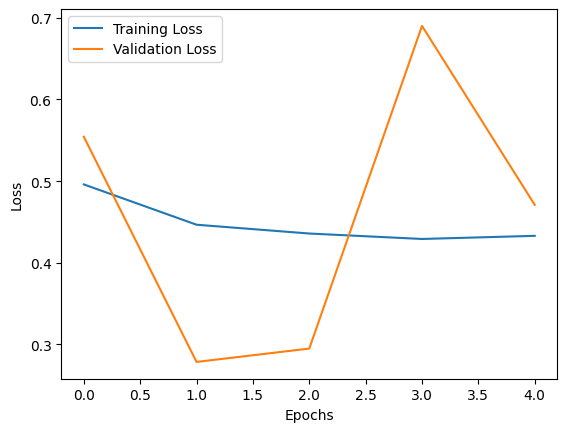

In [11]:
plt.plot(training_history_vgg.history['loss'], label='Training Loss')
plt.plot(training_history_vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

vgg_checkpoint = ModelCheckpoint('vgg_best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [12]:
print(report_test)

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      4418
           1       0.98      0.85      0.91      8405

    accuracy                           0.89     12823
   macro avg       0.88      0.91      0.89     12823
weighted avg       0.91      0.89      0.89     12823



### 1(d) vi

The CNN+MLP model is the most balanced and highest-performing model among the four, suggesting that the combination of convolutional layers with a fully connected network (MLP) has been most effective for this particular task.
The EfficientNet model's performance is notably inadequate, which could be due to several factors that need investigation. It is not uncommon for certain architectures to require specific tweaks and optimizations to perform well on a given dataset.
The ResNet and VGG models show decent performance, but they are not as effective as the CNN+MLP model. This could be due to the inherent differences in how these architectures process features or possibly due to how they were fine-tuned and optimized during the training process.
In conclusion, the CNN+MLP model's architecture seems to be best suited for the given classification task, based on the provided dataset and the training setup.